# 🕳️ G2Net Keras [Training]

### Hi kagglers, This is `Training` notebook using `Keras`.

> 
>  [G2Net Keras [Inference]](https://www.kaggle.com/ammarnassanalhajali/g2net-keras-baseline-inference)



### Please if this kernel is useful, <font color='red'>please upvote !!</font>

# LB Scores

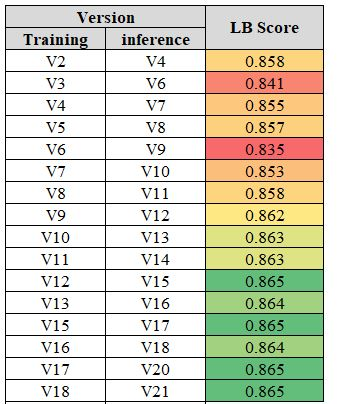

## ☀️ Importing Libraries

In [ ]:
import os
import json
import random
import collections
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import math
from random import shuffle

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.utils import Sequence
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
#from tensorflow.keras.models import Sequential


from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import model_selection as sk_model_selection



In [ ]:
!pip install -q nnAudio -qq
import torch
from nnAudio.Spectrogram import CQT1992v2

# Loading Data

In [ ]:
train = pd.read_csv('../input/g2net-gravitational-wave-detection/training_labels.csv')
sample_submission = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')
test=sample_submission

display(train.head(3))
display(test.head(3))

In [ ]:
sns.countplot(data=train, x="target")

In [ ]:
def get_train_file_path(image_id):
    return "../input/g2net-gravitational-wave-detection/train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

def get_test_file_path(image_id):
    return "../input/g2net-gravitational-wave-detection/test/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

display(train.head(3))
display(test.head(3))

# EDA

#### Each data sample (npy file) contains 3 time series (1 for each detector) and each spans 2 sec and is sampled at 2,048 Hz.

In [ ]:
Q_TRANSFORM = CQT1992v2(sr=4096, fmin=20, fmax=1024, hop_length=32)

def visualize_sample_qtransform(
    _id, 
    pathx,
    target,
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo"),
    sr=4096,
):
    x = np.load(pathx)
    plt.figure(figsize=(16, 3))
    for i in range(3):
        waves = x[i] / np.max(x[i])
        waves = torch.from_numpy(waves).float()
        image = Q_TRANSFORM(waves)
        
        plt.subplot(1, 3, i + 1)
        plt.imshow(image.squeeze())
        plt.title(signal_names[i], fontsize=14)

    plt.suptitle(f"id: {_id}  -----  Target: {target}", fontsize=16)
    plt.show()

In [ ]:
for i in random.sample(train.index.tolist(), 1):
    _id = train.iloc[i]["id"]
    _path = train.iloc[i]["file_path"]
    target = train.iloc[i]["target"]
    visualize_sample_qtransform(_id,_path, target)

# Splitting Data

In [ ]:
df_train, df_valid = sk_model_selection.train_test_split(
    train, 
    test_size=0.05, 
    random_state=14, 
    stratify=train["target"],
)
print("df_train:",len(df_train))
print("df_valid:",len(df_valid))

#  Custom Data Generator

In [ ]:
def create_cqt_image(wave, hop_length=16):
    CQTs = []
    for i in range(3):
        x = wave[i]
        x = tf.expand_dims(tf.expand_dims(x, 0), 2)
        x = tf.pad(x, PADDING, "REFLECT")

        CQT_real = tf.nn.conv1d(x, CQT_KERNELS_REAL, stride=hop_length, padding="VALID")
        CQT_imag = -tf.nn.conv1d(x, CQT_KERNELS_IMAG, stride=hop_length, padding="VALID")
        CQT_real *= tf.math.sqrt(LENGTHS)
        CQT_imag *= tf.math.sqrt(LENGTHS)

        CQT = tf.math.sqrt(tf.pow(CQT_real, 2) + tf.pow(CQT_imag, 2))
        CQTs.append(CQT[0])
    return tf.stack(CQTs, axis=2)

In [ ]:
class Dataset(Sequence):
    def __init__(self,df,is_train=True,batch_size=32,shuffle=True):
        self.idx = df["id"].values
        self.paths = df["file_path"].values
        self.y =  df["target"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.wave_transform = CQT1992v2(sr=4096, fmin=5, fmax=2048, hop_length=32)
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
    
    def apply_qtransform(self,pathx,transform): 
        waves = np.load(pathx)
        waves = np.hstack(waves)
        waves = waves / np.max(waves)
        waves = torch.from_numpy(waves).float()
        image = transform(waves)
        image = np.array(image)
        image = np.transpose(image,(1,2,0))
        #image = cv2.merge((image,image,image))
        image = tf.image.resize(image, size=(224, 224))
        return image
    
    def __getitem__(self,ids):
        batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
            
        list_x = np.array([self.apply_qtransform(x,self.wave_transform) for x in batch_paths])
        batch_X = np.stack(list_x)
        if self.is_train:
            return batch_X, batch_y
        else:
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.y))
            shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))

In [ ]:
train_dataset = Dataset(df_train)
valid_dataset = Dataset(df_valid)
#test_dataset = Dataset(test,is_train=False)
for i in range(1):
    image, label = train_dataset[i]
    print(image.shape)
    plt.imshow(image[0])
    plt.show()

# Model

In [ ]:
!pip install -U efficientnet

In [ ]:
import efficientnet.keras as efn

In [ ]:
def create_model(): 
    inputs = layers.Input(shape=(224,224,1))
    efficientnet_layers = efn.EfficientNetB0(include_top=False,input_shape=(),weights='imagenet',pooling='avg')
    model = Sequential()
    
    model.add(inputs)
    model.add(keras.layers.Conv2D(3,3,activation='relu',padding='same'))
    model.add(efficientnet_layers)
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    
    model.compile(optimizer = Adam(lr = 0.001),
                loss = "binary_crossentropy",
                metrics = ["acc"])

    return model

model = create_model()
model.summary()
    
    


# Training

In [ ]:
ckpt = tf.keras.callbacks.ModelCheckpoint(
    "model_weights.h5", save_best_only=True, save_weights_only=True,
)

train_history = model.fit(
    train_dataset,
    epochs = 2,
    validation_data = valid_dataset,
    callbacks=[ckpt]
)

# References

1. https://www.kaggle.com/mrigendraagrawal/tf-g2net-eda-and-starter
1. https://www.kaggle.com/yasufuminakama/g2net-efficientnet-b7-baseline-inference
1. https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
1. https://www.kaggle.com/yasufuminakama/g2net-efficientnet-b7-baseline-training
1. https://www.kaggle.com/hidehisaarai1213/g2net-tf-on-the-fly-cqt-tpu-training/